#Caderno Base para avaliação de modelos
Este caderno fornece um passo a passo para teste de modelos de classificação/predição para determinar se um novo registro de desastre terá seu pedido de Reconhecimento Federal deferido ou não.

O Classificador defino é treinado com um grupo de teste a avaliado com validação cruzada sobre todo o conjunto de dados em cada uma das combinações de transformações indicadas no Índice do caderno.

##*Bibliotecas*

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Carregando dados
Lê os dados do arquivo consolidado (com tratamento), aplica codificação das variáveis categóricas, faz a separação das variáveis independentes e dependente e divide grupo de dados para treino e teste. Esta etapa é comum a todas às análises. Um DataFrame sem transformações (df_raw) é mantido em memória.

In [3]:
df_raw = pd.read_excel('/path/to/data/Danos_Consolidado.xls')
df_dummy = pd.get_dummies(df_raw,
                          columns=['UF','COBRADE','Mes_ocorr'])
y = df_raw.Status
X = df_dummy.drop(columns='Status')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                     random_state=42)


In [ ]:
# Conferindo
print(f'df_raw:\t{df_raw.shape}')
print(f'df_dummy:\t{df_dummy.shape}')
print(f'X:\t{X.shape}')
print(f'y:\t{y.shape}')
print(f'X_train:\t{X_train.shape}')
print(f'y_train:\t{y_train.shape}')
print(f'X_test:\t{X_test.shape}')
print(f'y_test:\t{y_test.shape}')

df_raw:	(28342, 52)
df_dummy:	(28342, 133)
X:	(28342, 132)
y:	(28342,)
X_train:	(22673, 132)
y_train:	(22673,)
X_test:	(5669, 132)
y_test:	(5669,)


##Instanciando o modelo de classificação/previsão
Crie um modelo de classificação, defina seus parâmetros básicos e o atribua à variável *classifier*.

In [10]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier()

##Avaliando modelo sem transformações de dados

In [11]:
classifier.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

###Resultados

Text(0.5, 1.0, 'Matriz de confusão - sem transformações')

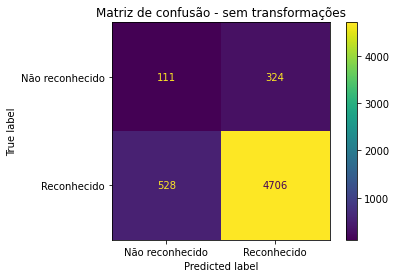

In [12]:
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - sem transformações')

In [ ]:
scores_ = cross_validate(classifier, X, np.where(y=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [14]:
print(f"F1 Score\tMédia: {scores_['test_f1'].mean():.5f} | Desvio: {scores_['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_['test_roc_auc'].mean():.5f} | Desvio: {scores_['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.94207 | Desvio: 0.02530
ROC_AUC		Média: 0.44601 | Desvio: 0.15347


##Avaliando modelo com normalização

In [15]:
scaler = StandardScaler().fit(X_train)

In [16]:
classifier.fit(scaler.transform(X_train),y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

###Resultados

Text(0.5, 1.0, 'Matriz de confusão - Normalizado')

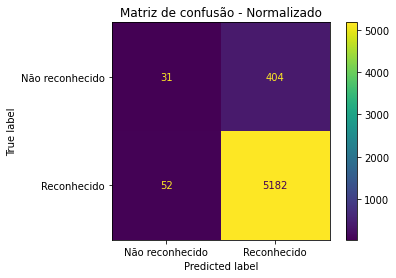

In [17]:
disp = plot_confusion_matrix(classifier, scaler.transform(X_test), y_test,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Normalizado')

In [18]:
scores_n = cross_validate(classifier, scaler.transform(X), np.where(y=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [19]:
print(f"F1 Score\tMédia: {scores_n['test_f1'].mean():.5f} | Desvio: {scores_n['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_n['test_roc_auc'].mean():.5f} | Desvio: {scores_n['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.93619 | Desvio: 0.01968
ROC_AUC		Média: 0.53852 | Desvio: 0.07522


##Avaliando modelo com balanceamento da variável dependente

###Undersampling da classe majoritária

In [20]:
rec = df_dummy[df_raw.Status=='Reconhecido']
nrec = df_dummy[df_raw.Status=='Não reconhecido']
df_ub = pd.concat([resample(rec,
                            replace = False,
                            n_samples = nrec.shape[0],
                            random_state = 42
                            ),
                   nrec
                   ]).sample(frac = 1, random_state=42)
y_ub = df_ub.Status
X_ub = df_ub.drop(columns='Status')
X_train_ub, X_test_ub, y_train_ub, y_test_ub = train_test_split(X_ub,y_ub,
                                                                test_size=0.2,
                                                                random_state=42
                                                                )

In [21]:
# Conferindo
print(f'df_ub:\t{df_ub.shape}')
print(f'X_ub:\t{X_ub.shape}')
print(f'y_ub:\t{y_ub.shape}')
print(f'X_train_ub:\t{X_train_ub.shape}')
print(f'y_train_ub:\t{y_train_ub.shape}')
print(f'X_test_ub:\t{X_test_ub.shape}')
print(f'y_test_ub:\t{y_test_ub.shape}')
print(f"{len(df_ub[df_ub.Status=='Reconhecido'])} | {len(df_ub[df_ub.Status=='Não reconhecido'])}")

df_ub:	(4466, 133)
X_ub:	(4466, 132)
y_ub:	(4466,)
X_train_ub:	(3572, 132)
y_train_ub:	(3572,)
X_test_ub:	(894, 132)
y_test_ub:	(894,)
2233 | 2233


In [22]:
classifier.fit(X_train_ub,y_train_ub)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

####Resultados

Text(0.5, 1.0, 'Matriz de confusão - Undersampling')

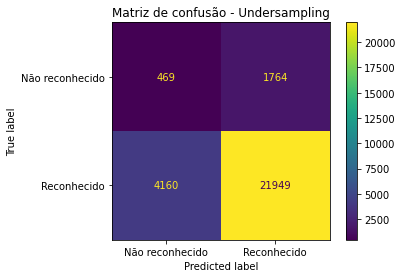

In [23]:
disp = plot_confusion_matrix(classifier, X, y,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Undersampling')

In [24]:
scores_ub = cross_validate(classifier, X, np.where(y=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [25]:
print(f"F1 Score\tMédia: {scores_ub['test_f1'].mean():.5f} | Desvio: {scores_ub['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_ub['test_roc_auc'].mean():.5f} | Desvio: {scores_ub['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.91237 | Desvio: 0.09165
ROC_AUC		Média: 0.46391 | Desvio: 0.14679


###Oversampling da classe Minoritária

In [26]:
rec = df_dummy[df_raw.Status=='Reconhecido']
nrec = df_dummy[df_raw.Status=='Não reconhecido']
df_ob = pd.concat([resample(nrec,
                            replace = True,
                            n_samples = rec.shape[0],
                            random_state = 42
                            ),
                   rec
                   ]).sample(frac = 1, random_state=42)
y_ob = df_ob.Status
X_ob = df_ob.drop(columns='Status')
X_train_ob, X_test_ob, y_train_ob, y_test_ob = train_test_split(X_ob,y_ob,
                                                                test_size=0.2,
                                                                random_state=42
                                                                )

In [27]:
# Conferindo
print(f'df_ob:\t{df_ob.shape}')
print(f'X_ob:\t{X_ob.shape}')
print(f'y_ob:\t{y_ob.shape}')
print(f'X_train_ob:\t{X_train_ob.shape}')
print(f'y_train_ob:\t{y_train_ob.shape}')
print(f'X_test_ob:\t{X_test_ob.shape}')
print(f'y_test_ob:\t{y_test_ob.shape}')
print(f"{len(df_ob[df_ob.Status=='Reconhecido'])} | {len(df_ob[df_ob.Status=='Não reconhecido'])}")

df_ob:	(52218, 133)
X_ob:	(52218, 132)
y_ob:	(52218,)
X_train_ob:	(41774, 132)
y_train_ob:	(41774,)
X_test_ob:	(10444, 132)
y_test_ob:	(10444,)
26109 | 26109


In [28]:
classifier.fit(X_train_ob,y_train_ob)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

####Resultados

Text(0.5, 1.0, 'Matriz de confusão - Oversampling')

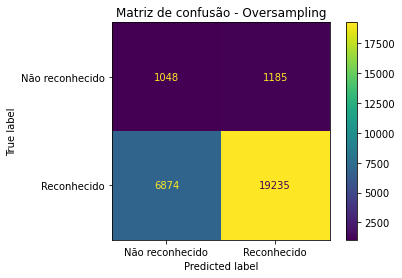

In [29]:
disp = plot_confusion_matrix(classifier, X, y,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Oversampling')

In [30]:
scores_ob = cross_validate(classifier, X, np.where(y=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [31]:
print(f"F1 Score\tMédia: {scores_ob['test_f1'].mean():.5f} | Desvio: {scores_ob['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_ob['test_roc_auc'].mean():.5f} | Desvio: {scores_ob['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.78509 | Desvio: 0.23992
ROC_AUC		Média: 0.46476 | Desvio: 0.15395


##Avaliando modelo com normalização e balanceamento da variável dependente

###Undersampling da classe majoritária com normalização

In [32]:
scaler.fit(X_train_ub)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [33]:
classifier.fit(scaler.transform(X_train_ub),y_train_ub)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

####Resultados

Text(0.5, 1.0, 'Matriz de confusão - Undersampling normalizado')

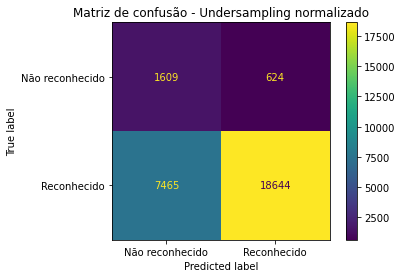

In [34]:
disp = plot_confusion_matrix(classifier, scaler.transform(X), y,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Undersampling normalizado')

In [35]:
scores_nub = cross_validate(classifier, scaler.transform(X_ub), np.where(y_ub=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [36]:
print(f"F1 Score\tMédia: {scores_nub['test_f1'].mean():.5f} | Desvio: {scores_nub['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_nub['test_roc_auc'].mean():.5f} | Desvio: {scores_nub['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.66515 | Desvio: 0.03753
ROC_AUC		Média: 0.70746 | Desvio: 0.03797


###Oversampling da classe Minoritária com normalização

In [37]:
scaler.fit(X_train_ob)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
classifier.fit(scaler.transform(X_train_ob),y_train_ob)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

####Resultados

Text(0.5, 1.0, 'Matriz de confusão - Undersampling normalizado')

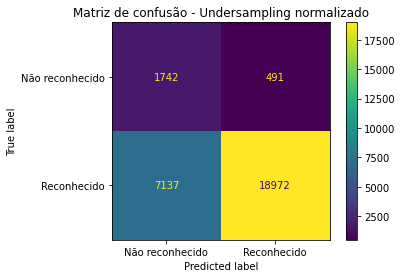

In [39]:
disp = plot_confusion_matrix(classifier, scaler.transform(X), y,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Undersampling normalizado')

In [40]:
scores_nob = cross_validate(classifier, scaler.transform(X), np.where(y=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [41]:
print(f"F1 Score\tMédia: {scores_nob['test_f1'].mean():.5f} | Desvio: {scores_nob['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_nob['test_roc_auc'].mean():.5f} | Desvio: {scores_nob['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.94261 | Desvio: 0.02573
ROC_AUC		Média: 0.60576 | Desvio: 0.10984


##Avaliando modelo com agrupamento de dados

In [42]:
dh_columns = [dh for dh in df_dummy if dh.startswith('DH_')]
dm_columns = [dm for dm in df_dummy if (dm.startswith('DM_') and not dm.endswith('Valor'))]
dmv_columns = [dmv for dmv in df_dummy if (dmv.startswith('DM_') and dmv.endswith('Valor'))]
da_columns = [da for da in df_dummy if da.startswith('DA_')]
pepl_columns = [pepl for pepl in df_dummy if pepl.startswith('PEPL_')]
pepr_columns = [pepr for pepr in df_dummy if pepr.startswith('PEPR_')]

df_gdummy = df_dummy.copy()
df_gdummy['Danos_Humanos'] = df_gdummy.loc[:,list(dh_columns)].sum(axis=1)
df_gdummy['Danos_Materiais'] = df_gdummy.loc[:,list(dm_columns)].sum(axis=1)
df_gdummy['Danos_Materiais_valor'] = df_gdummy.loc[:,list(dmv_columns)].sum(axis=1)
df_gdummy['Danos_Ambientais'] = df_gdummy.loc[:,list(da_columns)].sum(axis=1)
df_gdummy['PEPL'] = df_gdummy.loc[:,list(pepl_columns)].sum(axis=1)
df_gdummy['PEPR'] = df_gdummy.loc[:,list(pepr_columns)].sum(axis=1)

df_gdummy.drop(columns = dh_columns + dm_columns + dmv_columns + da_columns + pepl_columns + pepr_columns, inplace=True)

In [43]:
# Conferindo
df_gdummy.sample(10,random_state=42)

,Status,População,Atraso,UF_AC,UF_AL,UF_AM,UF_AP,UF_BA,UF_CE,UF_DF,UF_ES,UF_GO,UF_MA,UF_MG,UF_MS,UF_MT,UF_PA,UF_PB,UF_PE,UF_PI,UF_PR,UF_RJ,UF_RN,UF_RO,UF_RR,UF_RS,UF_SC,UF_SE,UF_SP,UF_TO,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,...,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15230,COBRADE_22110,COBRADE_22210,COBRADE_22220,COBRADE_23110,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,Mes_ocorr_Apr,Mes_ocorr_Aug,Mes_ocorr_Dec,Mes_ocorr_Feb,Mes_ocorr_Jan,Mes_ocorr_Jul,Mes_ocorr_Jun,Mes_ocorr_Mar,Mes_ocorr_May,Mes_ocorr_Nov,Mes_ocorr_Oct,Mes_ocorr_Sep,Danos_Humanos,Danos_Materiais,Danos_Materiais_valor,Danos_Ambientais,PEPL,PEPR
4771,Reconhecido,10213,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,10213,0,0.0,0.0,0.00,4500000.0
2464,Reconhecido,10215,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1300,2,150000.0,0.0,8770000.00,0.0
22140,Reconhecido,10390,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.00,0.0
12124,Reconhecido,18745,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,10017,0,0.0,60.0,150000.00,3500000.0
3589,Reconhecido,62793,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,62793,0,0.0,60.0,6500000.00,10400000.0
17552,Reconhecido,4110,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1980,0,0.0,60.0,42207.32,2567000.0
24801,Reconhecido,3746,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.00,0.0
6750,Não reconhecido,10223,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,45000.0,0.0,7000.00,0.0
14851,Reconhecido,385276,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.00,0.0
11827,Reconhecido,52279,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8256,713,3021000.0,15.0,1315000.00,3348000.0


In [44]:
X_g = df_gdummy.drop(columns='Status')
y_g = df_gdummy.Status

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g,y_g,
                                                            test_size=0.2,
                                                            random_state=42
                                                            )

In [45]:
# Conferindo
print(f'df_gdummy:\t{df_gdummy.shape}')
print(f'X_g:\t{X_g.shape}')
print(f'y_g:\t{y_g.shape}')
print(f'X_train_g:\t{X_train_g.shape}')
print(f'y_train_g:\t{y_train_g.shape}')
print(f'X_test_g:\t{X_test_g.shape}')
print(f'y_test_g:\t{y_test_g.shape}')

df_gdummy:	(28342, 93)
X_g:	(28342, 92)
y_g:	(28342,)
X_train_g:	(22673, 92)
y_train_g:	(22673,)
X_test_g:	(5669, 92)
y_test_g:	(5669,)


In [46]:
classifier.fit(X_train_g,y_train_g)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

###Resultados

Text(0.5, 1.0, 'Matriz de confusão - Agrupamento')

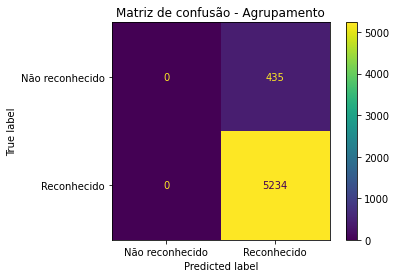

In [47]:
disp = plot_confusion_matrix(classifier, X_test_g, y_test_g,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Agrupamento')

In [48]:
scores_g = cross_validate(classifier, X_g, np.where(y_g=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [49]:
print(f"F1 Score\tMédia: {scores_g['test_f1'].mean():.5f} | Desvio: {scores_g['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_g['test_roc_auc'].mean():.5f} | Desvio: {scores_g['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.94166 | Desvio: 0.03553
ROC_AUC		Média: 0.43388 | Desvio: 0.14868


##Avaliando modelo com agrupamento e normalização

In [50]:
scaler.fit(X_train_g)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [51]:
classifier.fit(scaler.transform(X_train_g),y_train_g)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

###Resultados

Text(0.5, 1.0, 'Matriz de confusão - Agrupado Normalizado')

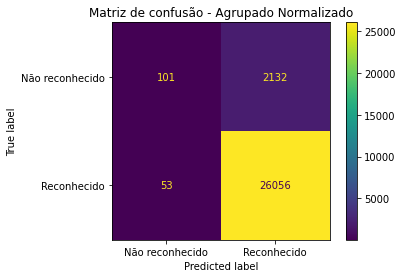

In [52]:
disp = plot_confusion_matrix(classifier, scaler.transform(X_g), y_g,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Agrupado Normalizado')

In [53]:
scores_ng = cross_validate(classifier, scaler.transform(X_g), np.where(y_g=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [54]:
print(f"F1 Score\tMédia: {scores_ng['test_f1'].mean():.5f} | Desvio: {scores_ng['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_ng['test_roc_auc'].mean():.5f} | Desvio: {scores_ng['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.94136 | Desvio: 0.03077
ROC_AUC		Média: 0.51372 | Desvio: 0.11431


##Avaliando modelo com agrupamento e balanceamento da variável dependente

###Undersampling da classe majoritária

In [55]:
rec = df_gdummy[df_raw.Status=='Reconhecido']
nrec = df_gdummy[df_raw.Status=='Não reconhecido']
df_gub = pd.concat([resample(rec,
                            replace = False,
                            n_samples = nrec.shape[0],
                            random_state = 42
                            ),
                   nrec
                   ]).sample(frac = 1, random_state=42)
y_gub = df_gub.Status
X_gub = df_gub.drop(columns='Status')
X_train_gub, X_test_gub, y_train_gub, y_test_gub = train_test_split(X_gub,y_gub,
                                                                test_size=0.2,
                                                                random_state=42
                                                                )

In [56]:
# Conferindo
print(f'df_gub:\t{df_gub.shape}')
print(f'X_gub:\t{X_gub.shape}')
print(f'y_gub:\t{y_gub.shape}')
print(f'X_train_gub:\t{X_train_gub.shape}')
print(f'y_train_gub:\t{y_train_gub.shape}')
print(f'X_test_gub:\t{X_test_gub.shape}')
print(f'y_test_gub:\t{y_test_gub.shape}')
print(f"{len(df_gub[df_gub.Status=='Reconhecido'])} | {len(df_gub[df_gub.Status=='Não reconhecido'])}")

df_gub:	(4466, 93)
X_gub:	(4466, 92)
y_gub:	(4466,)
X_train_gub:	(3572, 92)
y_train_gub:	(3572,)
X_test_gub:	(894, 92)
y_test_gub:	(894,)
2233 | 2233


In [57]:
classifier.fit(X_train_gub,y_train_gub)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

####Resultados

Text(0.5, 1.0, 'Matriz de confusão - Agrupado com Undersampling')

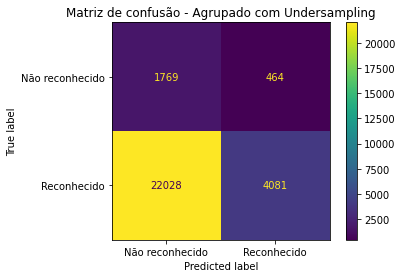

In [58]:
disp = plot_confusion_matrix(classifier, X_g, y_g,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Agrupado com Undersampling')

In [59]:
scores_gub = cross_validate(classifier, X_g, np.where(y_g=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [60]:
print(f"F1 Score\tMédia: {scores_gub['test_f1'].mean():.5f} | Desvio: {scores_gub['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_gub['test_roc_auc'].mean():.5f} | Desvio: {scores_gub['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.92330 | Desvio: 0.07398
ROC_AUC		Média: 0.39078 | Desvio: 0.15689


###Oversampling da classe Minoritária

In [61]:
rec = df_gdummy[df_raw.Status=='Reconhecido']
nrec = df_gdummy[df_raw.Status=='Não reconhecido']
df_gob = pd.concat([resample(nrec,
                            replace = True,
                            n_samples = rec.shape[0],
                            random_state = 42
                            ),
                   rec
                   ]).sample(frac = 1, random_state=42)
y_gob = df_gob.Status
X_gob = df_gob.drop(columns='Status')
X_train_gob, X_test_gob, y_train_gob, y_test_gob = train_test_split(X_gob,y_gob,
                                                                test_size=0.2,
                                                                random_state=42
                                                                )

In [62]:
# Conferindo
print(f'df_gob:\t{df_gob.shape}')
print(f'X_gob:\t{X_gob.shape}')
print(f'y_gob:\t{y_gob.shape}')
print(f'X_train_gob:\t{X_train_gob.shape}')
print(f'y_train_gob:\t{y_train_gob.shape}')
print(f'X_test_gob:\t{X_test_gob.shape}')
print(f'y_test_gob:\t{y_test_gob.shape}')
print(f"{len(df_gob[df_gob.Status=='Reconhecido'])} | {len(df_gob[df_gob.Status=='Não reconhecido'])}")

df_gob:	(52218, 93)
X_gob:	(52218, 92)
y_gob:	(52218,)
X_train_gob:	(41774, 92)
y_train_gob:	(41774,)
X_test_gob:	(10444, 92)
y_test_gob:	(10444,)
26109 | 26109


In [63]:
classifier.fit(X_train_gob,y_train_gob)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

####Resultados

Text(0.5, 1.0, 'Matriz de confusão - Agrupado com Oversampling')

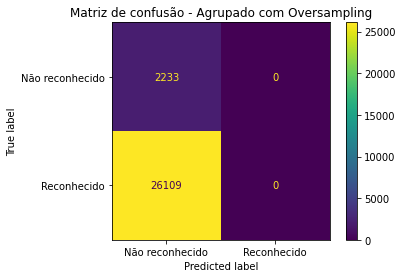

In [64]:
disp = plot_confusion_matrix(classifier, X_g, y_g,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Agrupado com Oversampling')

In [65]:
scores_gob = cross_validate(classifier, X_g, np.where(y_g=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [66]:
print(f"F1 Score\tMédia: {scores_gob['test_f1'].mean():.5f} | Desvio: {scores_gob['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_gob['test_roc_auc'].mean():.5f} | Desvio: {scores_gob['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.90023 | Desvio: 0.09022
ROC_AUC		Média: 0.35797 | Desvio: 0.14050


##Avaliando modelo com agrupamento, normalização e balanceamento da variável dependente

###Undersampling da classe majoritária com normalização

In [67]:
scaler.fit(X_train_gub)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [68]:
classifier.fit(scaler.transform(X_train_gub),y_train_gub)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

####Resultados

Text(0.5, 1.0, 'Matriz de confusão - Undersampling normalizado')

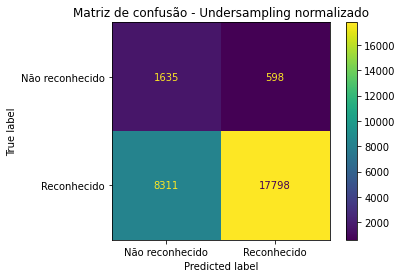

In [69]:
disp = plot_confusion_matrix(classifier, scaler.transform(X_g), y_g,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Undersampling normalizado')

In [70]:
scores_ngub = cross_validate(classifier, scaler.transform(X_g), np.where(y_g=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

In [71]:
print(f"F1 Score\tMédia: {scores_ngub['test_f1'].mean():.5f} | Desvio: {scores_ngub['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_ngub['test_roc_auc'].mean():.5f} | Desvio: {scores_ngub['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.95195 | Desvio: 0.00758
ROC_AUC		Média: 0.61287 | Desvio: 0.08913


###Oversampling da classe Minoritária com normalização

In [72]:
scaler.fit(X_train_gob)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [73]:
classifier.fit(scaler.transform(X_train_gob),y_train_gob)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

####Resultados

Text(0.5, 1.0, 'Matriz de confusão - Undersampling normalizado')

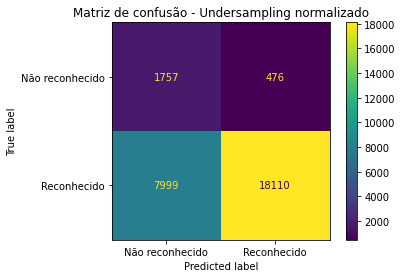

In [74]:
disp = plot_confusion_matrix(classifier, scaler.transform(X_g), y_g,
                             values_format='d',
                             normalize=None)
disp.ax_.set_title('Matriz de confusão - Undersampling normalizado')

In [75]:
scores_ngob = cross_validate(classifier, scaler.transform(X_g), np.where(y_g=='Reconhecido',1,0),
                        scoring=('f1','roc_auc'),
                        cv=10,
                        )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [76]:
print(f"F1 Score\tMédia: {scores_ngob['test_f1'].mean():.5f} | Desvio: {scores_ngob['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_ngob['test_roc_auc'].mean():.5f} | Desvio: {scores_ngob['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.95117 | Desvio: 0.01481
ROC_AUC		Média: 0.62224 | Desvio: 0.09430


In [77]:
print(f"F1 Score\tMédia: {scores_ngob['test_f1'].mean():.5f} | Desvio: {scores_ngob['test_f1'].std():.5f}")
print(f"ROC_AUC\t\tMédia: {scores_ngob['test_roc_auc'].mean():.5f} | Desvio: {scores_ngob['test_roc_auc'].std():.5f}")

F1 Score	Média: 0.95117 | Desvio: 0.01481
ROC_AUC		Média: 0.62224 | Desvio: 0.09430


##Compilação de métricas

In [78]:
metrics = [ x for x in dir() if x.startswith('score')]
print(f"Classifier is {classifier}")
for m in metrics:
    print(m)
    print(f"F1 Score\tMédia: {eval(m)['test_f1'].mean():.5f} | Desvio: {eval(m)['test_f1'].std():.5f}")
    print(f"ROC_AUC\t\tMédia: {eval(m)['test_roc_auc'].mean():.5f} | Desvio: {eval(m)['test_roc_auc'].std():.5f}")
    print('')

Classifier is SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
scores_
F1 Score	Média: 0.94207 | Desvio: 0.02530
ROC_AUC		Média: 0.44601 | Desvio: 0.15347

scores_g
F1 Score	Média: 0.94166 | Desvio: 0.03553
ROC_AUC		Média: 0.43388 | Desvio: 0.14868

scores_gob
F1 Score	Média: 0.90023 | Desvio: 0.09022
ROC_AUC		Média: 0.35797 | Desvio: 0.14050

scores_gub
F1 Score	Média: 0.92330 | Desvio: 0.07398
ROC_AUC		Média: 0.39078 | Desvio: 0.15689

scores_n
F1 Score	Média: 0.93619 | Desvio: 0.01968
ROC_AUC		Média: 0.53852 | Desvio: 0.07522

scores_ng
F1 Score	Média: 0.94136 | Desvio: 0.03077
ROC_AUC		Média: 0.51372 | Desvio: 0.1